In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

# Load the data
df = pd.read_excel(r"G:\2018\Documents\papers\Portfolio finance\Mixture of Experts\Book2.xlsx")

Epoch [1/10], Loss: 0.3224
Epoch [2/10], Loss: 0.1128
Epoch [3/10], Loss: 0.0783
Epoch [4/10], Loss: 0.0377
Epoch [5/10], Loss: 0.0208
Epoch [6/10], Loss: 0.0156
Epoch [7/10], Loss: 0.0162
Epoch [8/10], Loss: 0.0175
Epoch [9/10], Loss: 0.0160
Epoch [10/10], Loss: 0.0187
Training complete!


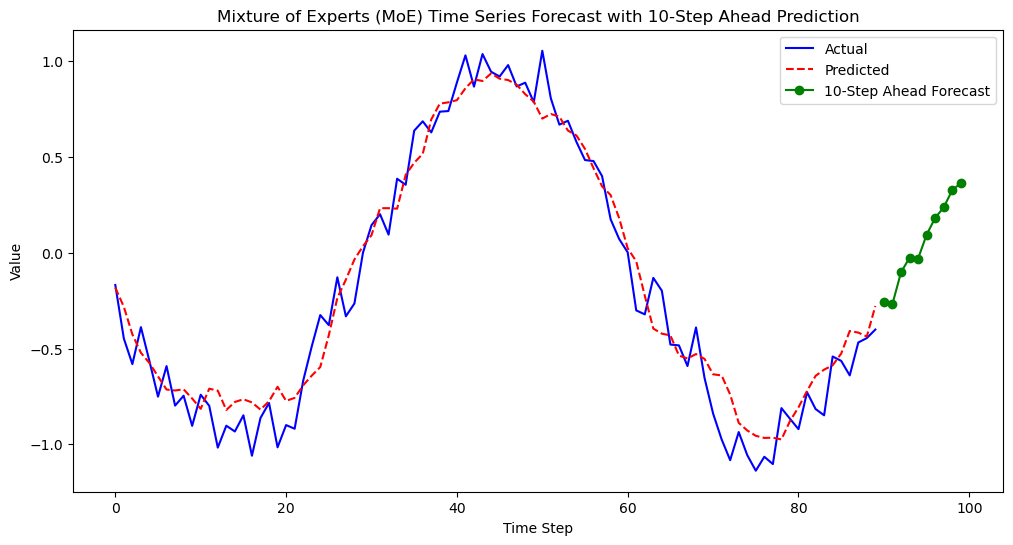

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Fix random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# ==============================
# Define Dataset Class
# ==============================
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return max(0, len(self.data) - self.seq_length)

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx:idx + self.seq_length], dtype=torch.float32)
        y = torch.tensor(self.data[idx + self.seq_length], dtype=torch.float32)
        return x, y

# ==============================
# Generate Synthetic Time Series Data
# ==============================
data_length = 500
seq_length = 10

data = np.sin(np.linspace(0, 50, data_length)) + np.random.normal(scale=0.1, size=data_length)

# Split into train and test sets
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

# Ensure train_data has enough samples
if len(train_data) <= seq_length:
    raise ValueError("Not enough training data for the given sequence length. Reduce seq_length.")

# Create datasets
train_dataset = TimeSeriesDataset(train_data, seq_length)
test_dataset = TimeSeriesDataset(test_data, seq_length)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# ==============================
# Define Mixture of Experts (MoE) Model
# ==============================
class LSTMExpert(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMExpert, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])  # Take last time step output

class MoE(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_experts):
        super(MoE, self).__init__()
        self.num_experts = num_experts
        self.experts = nn.ModuleList([LSTMExpert(input_size, hidden_size, output_size) for _ in range(num_experts)])
        self.gate = nn.Linear(input_size * seq_length, num_experts)  # Gating network

    def forward(self, x):
        batch_size = x.size(0)
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=2)
        x_flat = x.view(batch_size, -1)
        gating_weights = torch.softmax(self.gate(x_flat), dim=1)
        output = torch.bmm(expert_outputs, gating_weights.unsqueeze(2)).squeeze(2)
        return output

# ==============================
# Initialize Model, Loss, and Optimizer
# ==============================
input_size = 1
hidden_size = 64
output_size = 1
num_experts = 3

model = MoE(input_size, hidden_size, output_size, num_experts)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ==============================
# Training Loop
# ==============================
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for inputs, targets in train_loader:
        inputs = inputs.unsqueeze(-1)  # Add extra dimension for LSTM input
        targets = targets.unsqueeze(-1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

print("Training complete!")

# ==============================
# Evaluation on Test Set
# ==============================
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.unsqueeze(-1)  # Add extra dimension for LSTM input
        outputs = model(inputs)
        predictions.extend(outputs.squeeze().tolist())
        actuals.extend(targets.tolist())

# ==============================
# 5-Step Ahead Out-of-Sample Forecast
# ==============================
n_steps = 10  # Number of future steps to predict
forecasted_values = []

# Use the last 'seq_length' values from test data as input for forecasting
input_seq = torch.tensor(test_data[-seq_length:], dtype=torch.float32).unsqueeze(0).unsqueeze(-1)

model.eval()
with torch.no_grad():
    for _ in range(n_steps):
        next_pred = model(input_seq)  # Predict next value
        forecasted_values.append(next_pred.item())  # Store forecasted value

        # Shift input sequence and append new prediction
        input_seq = torch.cat((input_seq[:, 1:, :], next_pred.unsqueeze(1)), dim=1)

# ==============================
# Plot Results
# ==============================
plt.figure(figsize=(12, 6))

# Plot Actual Data
plt.plot(range(len(actuals)), actuals, label="Actual", color="blue")

# Plot Model Predictions
plt.plot(range(len(predictions)), predictions, label="Predicted", color="red", linestyle="dashed")

# Plot Future Forecast
future_indices = list(range(len(predictions), len(predictions) + n_steps))
plt.plot(future_indices, forecasted_values, label=f"{n_steps}-Step Ahead Forecast", color="green", marker="o")

plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title(f"Mixture of Experts (MoE) Time Series Forecast with {n_steps}-Step Ahead Prediction")
plt.show()

In [17]:
# Display the 10 forecasted data points
print("10-Step Ahead Forecasted Values:")
for i, value in enumerate(forecasted_values, start=1):
    print(f"Step {i}: {value:.4f}")

10-Step Ahead Forecasted Values:
Step 1: -0.2574
Step 2: -0.2674
Step 3: -0.1028
Step 4: -0.0255
Step 5: -0.0308
Step 6: 0.0939
Step 7: 0.1818
Step 8: 0.2369
Step 9: 0.3264
Step 10: 0.3641


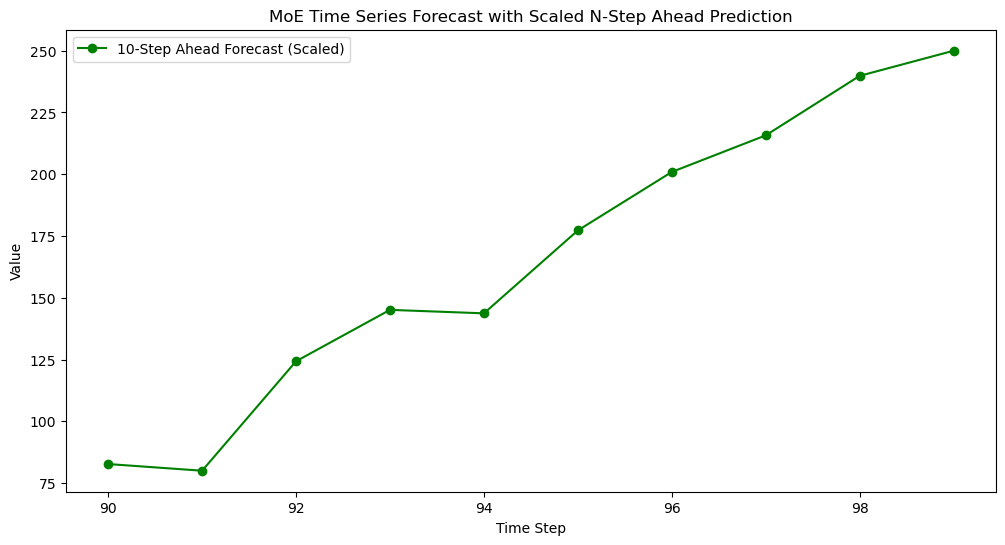

Forecasted Values (Scaled):
Time Step 90: 82.7000
Time Step 91: 80.0000
Time Step 92: 124.3095
Time Step 93: 145.1116
Time Step 94: 143.7024
Time Step 95: 177.2730
Time Step 96: 200.9278
Time Step 97: 215.7423
Time Step 98: 239.8275
Time Step 99: 250.0000

Forecasted Values (Original):
Time Step 90: -0.2574
Time Step 91: -0.2674
Time Step 92: -0.1028
Time Step 93: -0.0255
Time Step 94: -0.0308
Time Step 95: 0.0939
Time Step 96: 0.1818
Time Step 97: 0.2369
Time Step 98: 0.3264
Time Step 99: 0.3641


In [21]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# ... (Your existing code for loading data, creating sequences, defining MoE model, training, and forecasting) ...

# Assuming you have predictions and forecasted_values from your existing code

# Define the target range
target_min = 80
target_max = 250

# Scale the forecasted values
scaler = MinMaxScaler(feature_range=(target_min, target_max))
forecasted_values_scaled = scaler.fit_transform(np.array(forecasted_values).reshape(-1, 1)).flatten()

# Generate future indices
future_indices = list(range(len(predictions), len(predictions) + len(forecasted_values_scaled)))

# Plot Results
plt.figure(figsize=(12, 6))

# ... (Your existing code to plot actual and fitted values) ...

# Plot the scaled forecast
plt.plot(future_indices, forecasted_values_scaled, label=f"{len(forecasted_values_scaled)}-Step Ahead Forecast (Scaled)", color="green", marker="o")

plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("MoE Time Series Forecast with Scaled N-Step Ahead Prediction")
plt.show()

# Display the forecasted values (scaled)
print("Forecasted Values (Scaled):")
for i, value in enumerate(forecasted_values_scaled):
    print(f"Time Step {future_indices[i]}: {value:.4f}")

# Display the original forecasted values (unscaled)
print("\nForecasted Values (Original):")
for i, value in enumerate(forecasted_values):
    print(f"Time Step {future_indices[i]}: {value:.4f}")

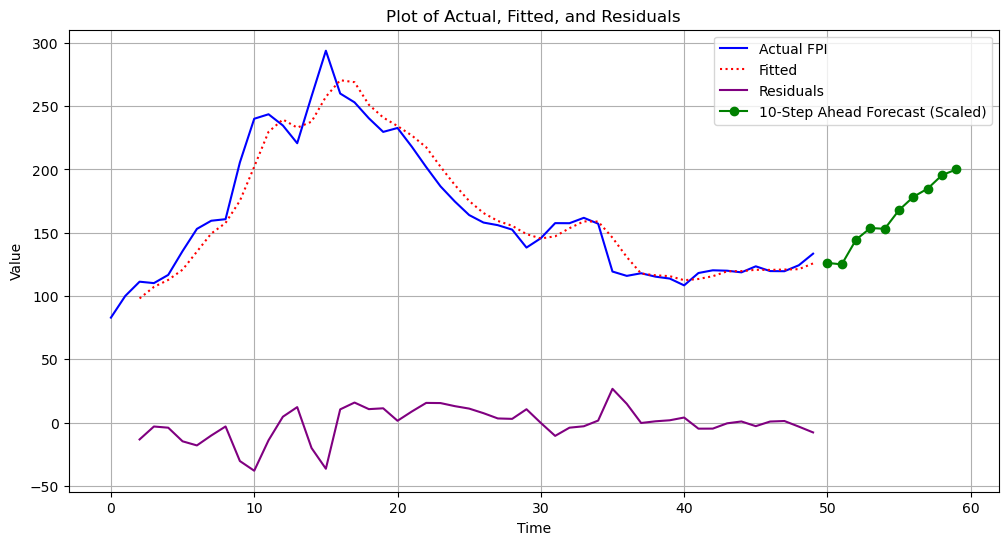


N-Step Ahead Out-of-Sample Forecasts:
Time Point 50: 126.1912
Time Point 51: 125.0000
Time Point 52: 144.5483
Time Point 53: 153.7257
Time Point 54: 153.1040
Time Point 55: 167.9146
Time Point 56: 178.3505
Time Point 57: 184.8863
Time Point 58: 195.5121
Time Point 59: 200.0000


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the data
df = pd.read_excel(r"G:\2018\Documents\papers\Portfolio finance\Mixture of Experts\Book2.xlsx")

# Model Fit 
#Calculate 3-point moving average
fittma = df['FPI'].rolling(window=3).mean()

# Residuals from model fit
#Calculate residuals
resid = fittma - df['FPI']

# ========================
# add the forecasted values
# Define the target range
target_min = 125
target_max = 200

# Assuming you have `predictions` and `forecasted_values` from your MoE model
# Example placeholders (replace with your actual data)
predictions = df['FPI'].values  # Example: all points from FPI

# =======================
# IMPORTANT: Replace the following line with your actual forecasted_values.
# For example, if your model returned a list of 10 forecasted values:
# forecasted_values = [100, 105, 110, 115, 120, 125, 130, 135, 140, 145]
forecasted_values = [82.7000, 80, 124.3095, 145.1116, 143.7024, 177.2730, 200.9278, 215.7423, 239.8275, 250] #manually put in the values



# Scale the forecasted values
scaler = MinMaxScaler(feature_range=(target_min, target_max))
forecasted_values_scaled = scaler.fit_transform(np.array(forecasted_values).reshape(-1, 1)).flatten()

# Generate future indices, starting at the end of df['FPI']
future_indices = list(range(len(df['FPI']), len(df['FPI']) + len(forecasted_values_scaled)))
# =========================

# Plot df['FPI'], fittma, and resid
plt.figure(figsize=(12, 6))  # Adjust figure size if needed

plt.plot(df['FPI'], color='blue', linestyle='-', label='Actual FPI')
plt.plot(fittma, color='red', linestyle=':', label='Fitted')
plt.plot(resid, color='purple', linestyle='-', label='Residuals')

# Plot the scaled forecast
plt.plot(future_indices, forecasted_values_scaled, label=f"{len(forecasted_values_scaled)}-Step Ahead Forecast (Scaled)", color="green", marker="o")

plt.title('Plot of Actual, Fitted, and Residuals')
plt.xlabel('Time')  # Or 'Time' if your index represents time
plt.ylabel('Value')
plt.grid(True)
plt.legend()  # Show legend
plt.show()

# Show point estimates of n-step ahead out-of-sample forecasts
print("\nN-Step Ahead Out-of-Sample Forecasts:")
for i, forecast in enumerate(forecasted_values_scaled):
    print(f"Time Point {future_indices[i]}: {forecast:.4f}")

Epoch [1/10], Train Loss: 0.4018, Val Loss: 0.2938
Epoch [2/10], Train Loss: 0.1434, Val Loss: 0.0968
Epoch [3/10], Train Loss: 0.0932, Val Loss: 0.0751
Epoch [4/10], Train Loss: 0.0669, Val Loss: 0.0558
Epoch [5/10], Train Loss: 0.0428, Val Loss: 0.0274
Epoch [6/10], Train Loss: 0.0213, Val Loss: 0.0151
Epoch [7/10], Train Loss: 0.0199, Val Loss: 0.0154
Epoch [8/10], Train Loss: 0.0178, Val Loss: 0.0172
Epoch [9/10], Train Loss: 0.0177, Val Loss: 0.0140
Epoch [10/10], Train Loss: 0.0175, Val Loss: 0.0157
Training complete!
Diagnostic Results:
Test MSE: 0.0170
Test MAE: 0.1073


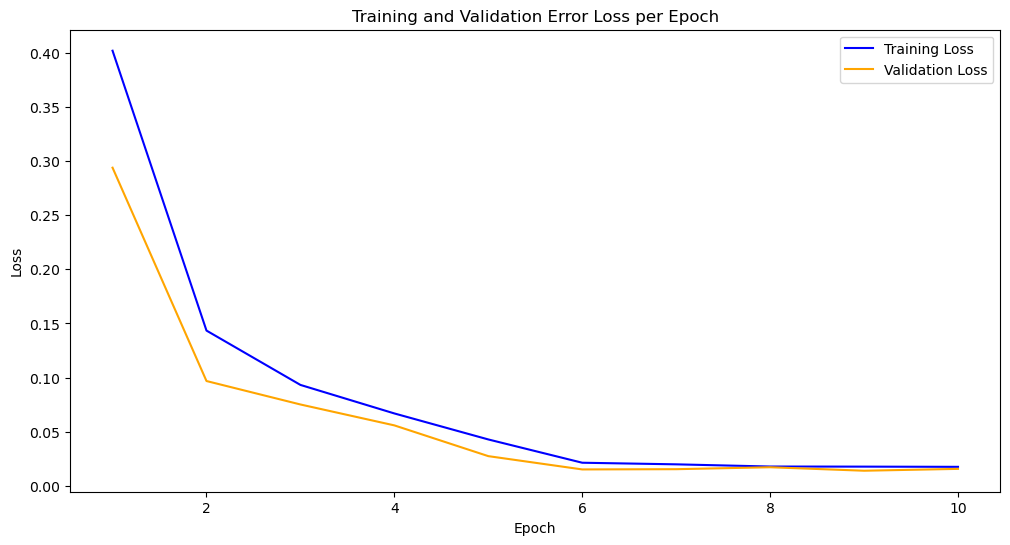

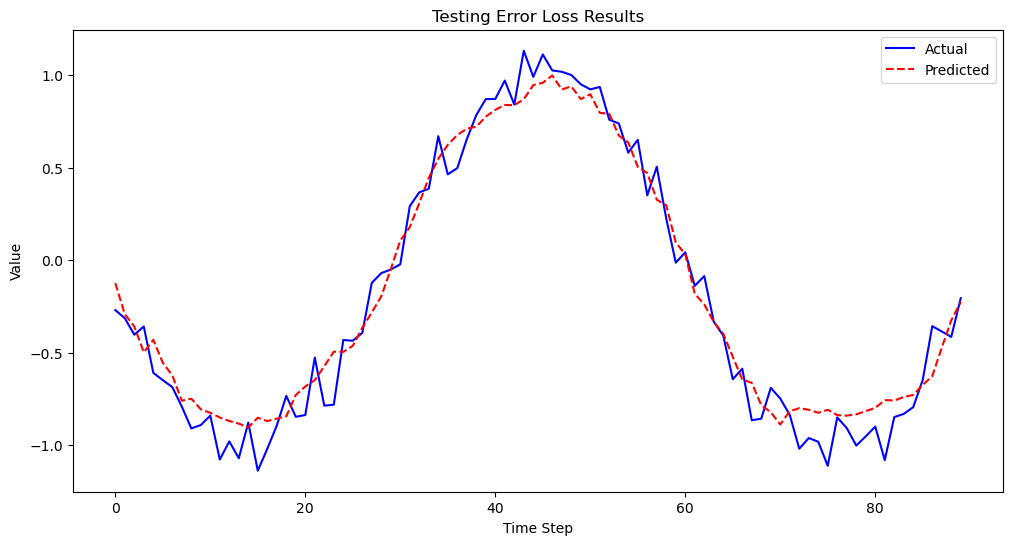


Training Diagnostic:
The training and validation loss plots show the loss decreasing over epochs, indicating the model is learning. If the loss plateaus, it means the model has converged. If the training loss decreases significantly and the validation loss increases, it might indicate overfitting.

Testing Diagnostic:
Test MSE: 0.0170
Test MAE: 0.1073
The Test MSE and MAE provide a quantitative measure of the model's performance on unseen data. Lower values indicate better performance. These metrics help assess how well the model generalizes to new data.


In [27]:
#Diagnostic Test

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming you have a DataFrame 'df' with a column 'FPI'
# If you don't, create a sample DataFrame for demonstration:
data_length = 500
time_index = pd.date_range(start='2023-01-01', periods=data_length, freq='D')
df = pd.DataFrame({
    'FPI': np.sin(np.linspace(0, 50, data_length)) + np.random.normal(scale=0.1, size=data_length)
}, index=time_index)

# Extract the 'FPI' column as a NumPy array
data = df['FPI'].values

# ==============================
# Define Dataset Class
# ==============================
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return max(0, len(self.data) - self.seq_length)

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx:idx + self.seq_length], dtype=torch.float32)
        y = torch.tensor(self.data[idx + self.seq_length], dtype=torch.float32)
        return x, y

# ==============================
# Set Sequence Length and Split Data
# ==============================
seq_length = 10

train_size = int(0.6 * len(data))  # Adjust splits for validation
val_size = int(0.2 * len(data))
train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]

if len(train_data) <= seq_length or len(val_data) <= seq_length or len(test_data) <= seq_length:
    raise ValueError("Not enough data for the given sequence length. Reduce seq_length or adjust split sizes.")

# Create datasets and DataLoaders
train_dataset = TimeSeriesDataset(train_data, seq_length)
val_dataset = TimeSeriesDataset(val_data, seq_length)
test_dataset = TimeSeriesDataset(test_data, seq_length)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# ==============================
# Define Mixture of Experts (MoE) Model
# ==============================
class LSTMExpert(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMExpert, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

class MoE(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_experts):
        super(MoE, self).__init__()
        self.num_experts = num_experts
        self.experts = nn.ModuleList([LSTMExpert(input_size, hidden_size, output_size) for _ in range(num_experts)])
        self.gate = nn.Linear(input_size * seq_length, num_experts)

    def forward(self, x):
        batch_size = x.size(0)
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=2)
        x_flat = x.view(batch_size, -1)
        gating_weights = torch.softmax(self.gate(x_flat), dim=1)
        output = torch.bmm(expert_outputs, gating_weights.unsqueeze(2)).squeeze(2)
        return output

# ==============================
# Initialize Model, Loss, and Optimizer
# ==============================
input_size = 1
hidden_size = 64
output_size = 1
num_experts = 3

model = MoE(input_size, hidden_size, output_size, num_experts)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ==============================
# Training Loop
# ==============================
num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    total_val_loss = 0.0

    for inputs, targets in train_loader:
        inputs = inputs.unsqueeze(-1)
        targets = targets.unsqueeze(-1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.unsqueeze(-1)
            targets = targets.unsqueeze(-1)
            outputs = model(inputs)
            val_loss = criterion(outputs, targets)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

print("Training complete!")

# ==============================
# Evaluation on Test Set
# ==============================
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.unsqueeze(-1)
        outputs = model(inputs)
        predictions.extend(outputs.squeeze().tolist())
        actuals.extend(targets.tolist())

# ==============================
# Calculate and Print Metrics
# ==============================
test_mse = mean_squared_error(actuals, predictions)
test_mae = mean_absolute_error(actuals, predictions)

print("Diagnostic Results:")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# ==============================
# Plot Results
# ==============================
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", color="blue")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Error Loss per Epoch")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(len(actuals)), actuals, label="Actual", color="blue")
plt.plot(range(len(predictions)), predictions, label="Predicted", color="red", linestyle="dashed")
plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Testing Error Loss Results")
plt.show()

#Diagnostic output
print("\nTraining Diagnostic:")
print("The training and validation loss plots show the loss decreasing over epochs, indicating the model is learning. If the loss plateaus, it means the model has converged. If the training loss decreases significantly and the validation loss increases, it might indicate overfitting.")

print("\nTesting Diagnostic:")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print("The Test MSE and MAE provide a quantitative measure of the model's performance on unseen data. Lower values indicate better performance. These metrics help assess how well the model generalizes to new data.")